Creating a model that determines whether or not an object of interest is an exoplanet.

In [32]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
import plotly.express as px
import plotly.figure_factory as ff
from IPython.display import Image
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

pd.set_option('display.max_columns', None)


In [17]:
df = pd.read_csv('cumulative.csv')
df

,rowid,kepid,kepoi_name,kepler_name,koi_disposition,koi_pdisposition,koi_score,koi_fpflag_nt,koi_fpflag_ss,koi_fpflag_co,koi_fpflag_ec,koi_period,koi_period_err1,koi_period_err2,koi_time0bk,koi_time0bk_err1,koi_time0bk_err2,koi_impact,koi_impact_err1,koi_impact_err2,koi_duration,koi_duration_err1,koi_duration_err2,koi_depth,koi_depth_err1,koi_depth_err2,koi_prad,koi_prad_err1,koi_prad_err2,koi_teq,koi_teq_err1,koi_teq_err2,koi_insol,koi_insol_err1,koi_insol_err2,koi_model_snr,koi_tce_plnt_num,koi_tce_delivname,koi_steff,koi_steff_err1,koi_steff_err2,koi_slogg,koi_slogg_err1,koi_slogg_err2,koi_srad,koi_srad_err1,koi_srad_err2,ra,dec,koi_kepmag
0,1,10797460,K00752.01,Kepler-227 b,CONFIRMED,CANDIDATE,1.000,0,0,0,0,9.488036,2.775000e-05,-2.775000e-05,170.538750,0.002160,-0.002160,0.146,0.318,-0.146,2.95750,0.08190,-0.08190,615.8,19.5,-19.5,2.26,0.26,-0.15,793.0,NaN,NaN,93.59,29.45,-16.65,35.8,1.0,q1_q17_dr25_tce,5455.0,81.0,-81.0,4.467,0.064,-0.096,0.927,0.105,-0.061,291.93423,48.141651,15.347
1,2,10797460,K00752.02,Kepler-227 c,CONFIRMED,CANDIDATE,0.969,0,0,0,0,54.418383,2.479000e-04,-2.479000e-04,162.513840,0.003520,-0.003520,0.586,0.059,-0.443,4.50700,0.11600,-0.11600,874.8,35.5,-35.5,2.83,0.32,-0.19,443.0,NaN,NaN,9.11,2.87,-1.62,25.8,2.0,q1_q17_dr25_tce,5455.0,81.0,-81.0,4.467,0.064,-0.096,0.927,0.105,-0.061,291.93423,48.141651,15.347
2,3,10811496,K00753.01,NaN,FALSE POSITIVE,FALSE POSITIVE,0.000,0,1,0,0,19.899140,1.494000e-05,-1.494000e-05,175.850252,0.000581,-0.000581,0.969,5.126,-0.077,1.78220,0.03410,-0.03410,10829.0,171.0,-171.0,14.60,3.92,-1.31,638.0,NaN,NaN,39.30,31.04,-10.49,76.3,1.0,q1_q17_dr25_tce,5853.0,158.0,-176.0,4.544,0.044,-0.176,0.868,0.233,-0.078,297.00482,48.134129,15.436
3,4,10848459,K00754.01,NaN,FALSE POSITIVE,FALSE POSITIVE,0.000,0,1,0,0,1.736952,2.630000e-07,-2.630000e-07,170.307565,0.000115,-0.000115,1.276,0.115,-0.092,2.40641,0.00537,-0.00537,8079.2,12.8,-12.8,33.46,8.50,-2.83,1395.0,NaN,NaN,891.96,668.95,-230.35,505.6,1.0,q1_q17_dr25_tce,5805.0,157.0,-174.0,4.564,0.053,-0.168,0.791,0.201,-0.067,285.53461,48.285210,15.597
4,5,10854555,K00755.01,Kepler-664 b,CONFIRMED,CANDIDATE,1.000,0,0,0,0,2.525592,3.761000e-06,-3.761000e-06,171.595550,0.001130,-0.001130,0.701,0.235,-0.478,1.65450,0.04200,-0.04200,603.3,16.9,-16.9,2.75,0.88,-0.35,1406.0,NaN,NaN,926.16,874.33,-314.24,40.9,1.0,q1_q17_dr25_tce,6031.0,169.0,-211.0,4.438,0.070,-0.210,1.046,0.334,-0.133,288.75488,48.226200,15.509
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9559,9560,10031643,K07984.01,NaN,FALSE POSITIVE,FALSE POSITIVE,0.000,0,0,0,1,8.589871,1.846000e-04,-1.846000e-04,132.016100,0.015700,-0.015700,0.765,0.023,-0.541,4.80600,0.63400,-0.63400,87.7,13.0,-13.0,1.11,0.32,-0.23,929.0,NaN,NaN,176.40,152.77,-77.60,8.4,1.0,q1_q17_dr25_tce,5638.0,169.0,-152.0,4.296,0.231,-0.189,1.088,0.313,-0.228,298.74921,46.973351,14.478
9560,9561,10090151,K07985.01,NaN,FALSE POSITIVE,FALSE POSITIVE,0.000,0,1,1,0,0.527699,1.160000e-07,-1.160000e-07,131.705093,0.000170,-0.000170,1.252,0.051,-0.049,3.22210,0.01740,-0.01740,1579.2,4.6,-4.6,29.35,7.70,-2.57,2088.0,NaN,NaN,4500.53,3406.38,-1175.26,453.3,1.0,q1_q17_dr25_tce,5638.0,139.0,-166.0,4.529,0.035,-0.196,0.903,0.237,-0.079,297.18875,47.093819,14.082
9561,9562,10128825,K07986.01,NaN,CANDIDATE,CANDIDATE,0.497,0,0,0,0,1.739849,1.780000e-05,-1.780000e-05,133.001270,0.007690,-0.007690,0.043,0.423,-0.043,3.11400,0.22900,-0.22900,48.5,5.4,-5.4,0.72,0.24,-0.08,1608.0,NaN,NaN,1585.81,1537.86,-502.22,10.6,1.0,q1_q17_dr25_tce,6119.0,165.0,-220.0,4.444,0.056,-0.224,1.031,0.341,-0.114,286.50937,47.163219,14.757
9562,9563,10147276,K07987.01,NaN,FALSE POSITIVE,FALSE POSITIVE,0.021,0,0,1,0,0.681402,2.434000e-06,-2.434000e-06,132.181750,0.002850,-0.002850,0.147,0.309,-0.147,0.86500,0.16200,-0.16200,103.6,14.7,-14.7,1.07,0.36,-0.11,2218.0,NaN,NaN,5713.41,5675.74,-1836.94,12

Dropping rows where koi_disposition is 'CANDIDATE'. joi_fpflags are human observations which gives to much information. I realized this after a XGBoost Classifier was predicting 99% accuracy. Dropping identifier columns, predicted disposition, score, right ascension and declination which don't contribute anything.

In [18]:
df = df[(df['koi_disposition'] == 'CONFIRMED') | (df['koi_disposition'] == 'FALSE POSITIVE')]
df['koi_disposition'] = df['koi_disposition'].map({'FALSE POSITIVE':0,'CONFIRMED':1})
df = df.drop(['rowid', 'kepid', 'kepoi_name', 'kepler_name','koi_fpflag_nt', 'koi_fpflag_ss', 'koi_fpflag_co', 'koi_fpflag_ec', 'koi_pdisposition', 'koi_score', 'koi_tce_delivname', 'ra', 'dec', 'koi_tce_plnt_num'],axis=1)

In [19]:
df.dtypes.to_frame().T

,koi_disposition,koi_period,koi_period_err1,koi_period_err2,koi_time0bk,koi_time0bk_err1,koi_time0bk_err2,koi_impact,koi_impact_err1,koi_impact_err2,koi_duration,koi_duration_err1,koi_duration_err2,koi_depth,koi_depth_err1,koi_depth_err2,koi_prad,koi_prad_err1,koi_prad_err2,koi_teq,koi_teq_err1,koi_teq_err2,koi_insol,koi_insol_err1,koi_insol_err2,koi_model_snr,koi_steff,koi_steff_err1,koi_steff_err2,koi_slogg,koi_slogg_err1,koi_slogg_err2,koi_srad,koi_srad_err1,koi_srad_err2,koi_kepmag
0,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64


In [20]:
df.isnull().sum().to_frame().T

,koi_disposition,koi_period,koi_period_err1,koi_period_err2,koi_time0bk,koi_time0bk_err1,koi_time0bk_err2,koi_impact,koi_impact_err1,koi_impact_err2,koi_duration,koi_duration_err1,koi_duration_err2,koi_depth,koi_depth_err1,koi_depth_err2,koi_prad,koi_prad_err1,koi_prad_err2,koi_teq,koi_teq_err1,koi_teq_err2,koi_insol,koi_insol_err1,koi_insol_err2,koi_model_snr,koi_steff,koi_steff_err1,koi_steff_err2,koi_slogg,koi_slogg_err1,koi_slogg_err2,koi_srad,koi_srad_err1,koi_srad_err2,koi_kepmag
0,0,0,377,377,0,377,377,300,377,377,0,377,377,300,377,377,300,300,300,300,7316,7316,259,259,259,300,300,397,412,300,397,397,300,397,397,1


Every value of koi_teq_err1 and koi_teq_err2 are null so we drop them. There also seems to be a common pattern of 377 null values so it looks like certain rows are missing a lot of data. Check this by picking one of the features with 377 null values.

In [21]:
df = df.drop(['koi_teq_err1', 'koi_teq_err2'],axis=1)
df[df['koi_duration_err1'].isnull()]

,koi_disposition,koi_period,koi_period_err1,koi_period_err2,koi_time0bk,koi_time0bk_err1,koi_time0bk_err2,koi_impact,koi_impact_err1,koi_impact_err2,koi_duration,koi_duration_err1,koi_duration_err2,koi_depth,koi_depth_err1,koi_depth_err2,koi_prad,koi_prad_err1,koi_prad_err2,koi_teq,koi_insol,koi_insol_err1,koi_insol_err2,koi_model_snr,koi_steff,koi_steff_err1,koi_steff_err2,koi_slogg,koi_slogg_err1,koi_slogg_err2,koi_srad,koi_srad_err1,koi_srad_err2,koi_kepmag
329,0,0.734525,NaN,NaN,133.431080,NaN,NaN,NaN,NaN,NaN,6.7000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.220
357,0,6.721078,NaN,NaN,134.777598,NaN,NaN,NaN,NaN,NaN,7.4600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14.792
371,0,1.592633,NaN,NaN,133.924380,NaN,NaN,0.003,NaN,NaN,5.5605,NaN,NaN,633.1,NaN,NaN,1.56,0.13,-0.12,1053.0,290.51,87.21,-73.46,66.9,4506.0,121.0,-135.0,4.626,0.042,-0.028,0.651,0.053,-0.053,15.470
490,0,200.611033,NaN,NaN,456.844440,NaN,NaN,NaN,NaN,NaN,7.1300,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15.783
492,0,1.634846,NaN,NaN,134.512115,NaN,NaN,NaN,NaN,NaN,6.1100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17098.40,21733.27,-11862.97,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.647
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9455,0,138.629025,NaN,NaN,235.373033,NaN,NaN,NaN,NaN,NaN,4.9300,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.555
9485,0,1.331993,NaN,NaN,132.647522,NaN,NaN,NaN,NaN,NaN,4.3300,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15.024
9500,0,272.542881,NaN,NaN,349.752734,NaN,NaN,0.287,NaN,NaN,3.0246,NaN,NaN,807.2,NaN,NaN,2.35,0.61,-0.20,255.0,1.00,0.76,-0.25,5.7,5677.0,152.0,-152.0,4.563,0.044,-0.176,0.828,0.216,-0.072,15.111
9534,0,236.257769,NaN,NaN,153.957093,NaN,NaN,0.085,NaN,NaN,3.3549,NaN,NaN,168.4,NaN,NaN,2.69,0.55,-0.83,460.0,10.61,6.41,-6.11,5.3,6645.0,167.0,-200.0,3.952,0.266,-0.114,2.054,0.421,-0.632,12.885


Most of those columns have many missing values, so we just drop these rows.

In [22]:
df = df[df['koi_duration_err1'].isnull() == False]
df.isnull().sum().to_frame().T

,koi_disposition,koi_period,koi_period_err1,koi_period_err2,koi_time0bk,koi_time0bk_err1,koi_time0bk_err2,koi_impact,koi_impact_err1,koi_impact_err2,koi_duration,koi_duration_err1,koi_duration_err2,koi_depth,koi_depth_err1,koi_depth_err2,koi_prad,koi_prad_err1,koi_prad_err2,koi_teq,koi_insol,koi_insol_err1,koi_insol_err2,koi_model_snr,koi_steff,koi_steff_err1,koi_steff_err2,koi_slogg,koi_slogg_err1,koi_slogg_err2,koi_srad,koi_srad_err1,koi_srad_err2,koi_kepmag
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,95,110,0,95,95,0,95,95,1


Created a heatmap, annoying process because I committed to not using seaborns heatmap and I wanted it to be color coded instead of have values displayed.

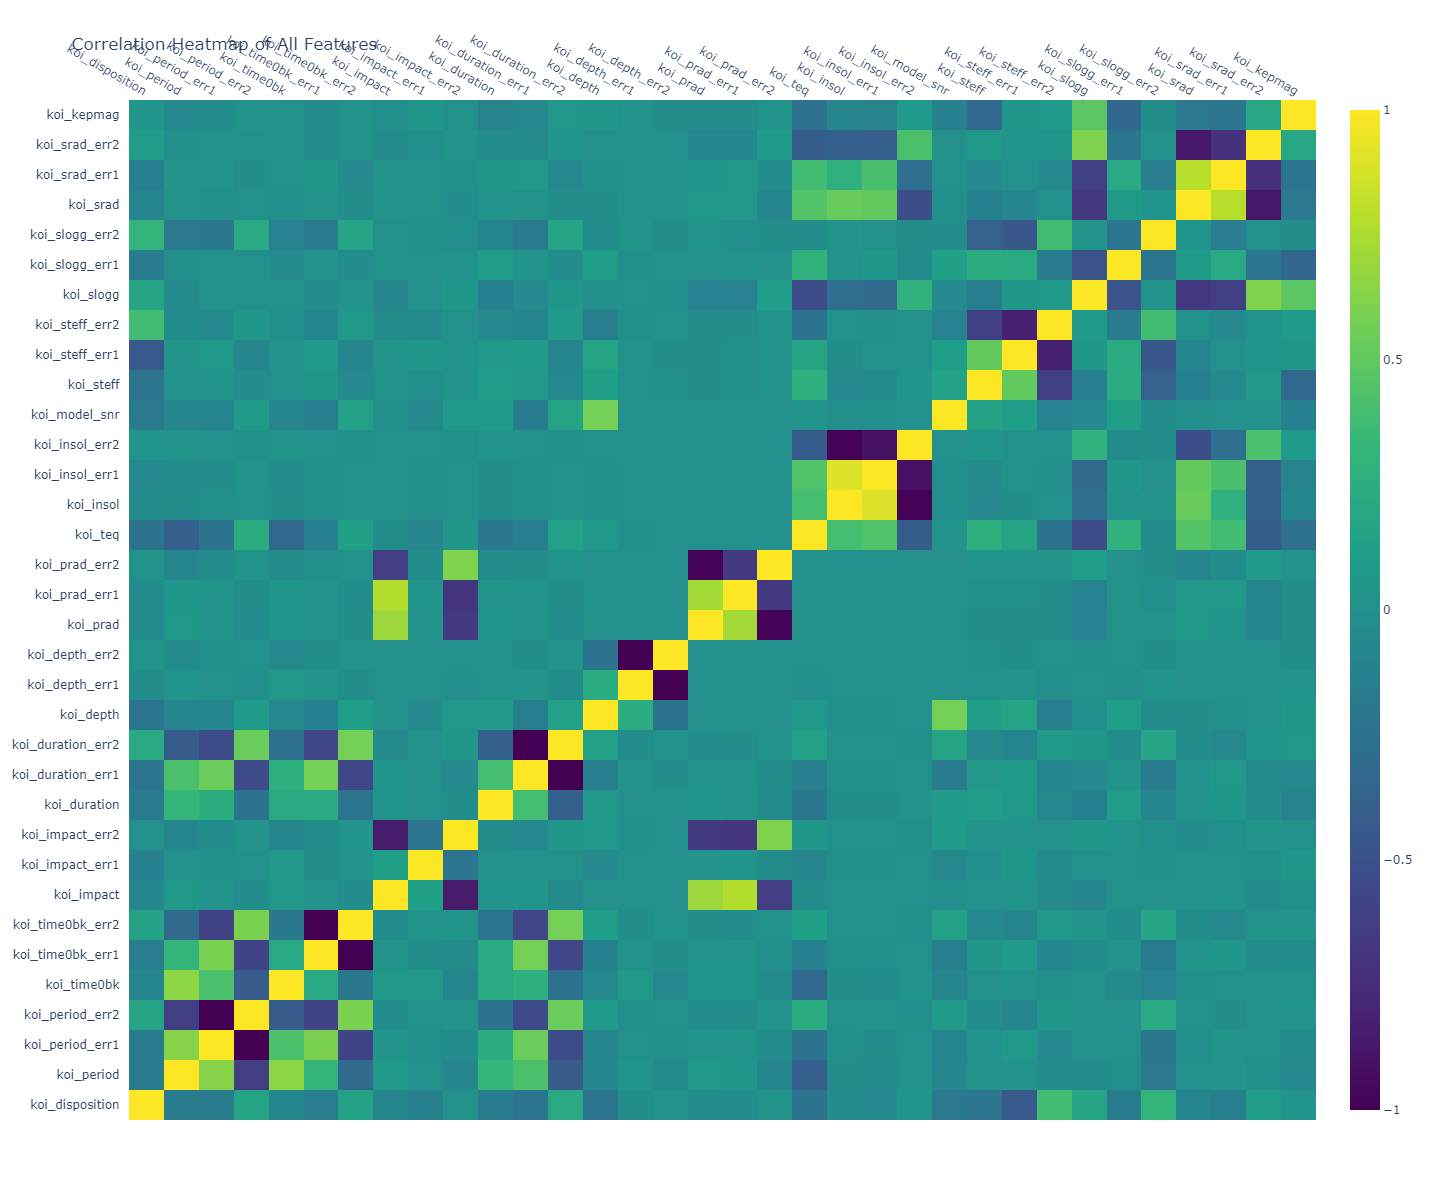

In [23]:
corr = df.corr()
z = np.round(corr.values, 2)

# Because I can't figure out how to get rid of the correlation numbers, I just made all of them blank
empty_text = [['' for _ in range(len(z))] for _ in range(len(z))]

fig = ff.create_annotated_heatmap(
    z=z,
    x=corr.columns.tolist(),
    y=corr.columns.tolist(),
    annotation_text=empty_text,
    showscale=True,
    colorscale='Viridis'
)
fig.update_layout(
    title='Correlation Heatmap of All Features',
    height=1200
)
Image("figures/heatmap.png")


Lots of clusters of correlated features. Most features are uncorrelated with each other. it looks like koi_steff_err features have the closest corelation to koi_disposition, our label. Although its only around 0.4.

Next is seperating the labels and splitting the data.

In [24]:
y = df['koi_disposition']
X = df.drop('koi_disposition',axis=1)
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=62, stratify=y)
X_train

,koi_period,koi_period_err1,koi_period_err2,koi_time0bk,koi_time0bk_err1,koi_time0bk_err2,koi_impact,koi_impact_err1,koi_impact_err2,koi_duration,koi_duration_err1,koi_duration_err2,koi_depth,koi_depth_err1,koi_depth_err2,koi_prad,koi_prad_err1,koi_prad_err2,koi_teq,koi_insol,koi_insol_err1,koi_insol_err2,koi_model_snr,koi_steff,koi_steff_err1,koi_steff_err2,koi_slogg,koi_slogg_err1,koi_slogg_err2,koi_srad,koi_srad_err1,koi_srad_err2,koi_kepmag
622,10.937256,4.273000e-05,-4.273000e-05,136.985490,0.002920,-0.002920,0.866,0.079,-0.595,3.0822,0.0987,-0.0987,421.6,18.2,-18.2,2.41,0.27,-0.32,777.0,86.28,26.58,-25.39,24.6,5334.0,79.0,-79.0,4.372,0.132,-0.077,1.004,0.111,-0.135,14.678
5950,1.018360,1.493000e-06,-1.493000e-06,131.677680,0.001820,-0.001820,0.553,0.035,-0.025,7.6220,0.0215,-0.0215,393970.0,540.0,-540.0,107.00,30.65,-30.64,2302.0,6627.64,5961.03,-3742.84,967.4,6160.0,216.0,-237.0,4.144,0.273,-0.168,1.463,0.419,-0.419,14.299
70,43.844397,9.613000e-05,-9.613000e-05,151.935380,0.001920,-0.001920,0.852,0.039,-0.585,6.8020,0.1190,-0.1190,615.2,7.7,-7.7,2.87,0.43,-0.30,531.0,18.77,7.98,-4.80,83.7,5854.0,105.0,-117.0,4.406,0.090,-0.110,1.012,0.154,-0.103,12.882
980,52.500864,1.465000e-04,-1.465000e-04,171.521140,0.002220,-0.002220,0.110,0.254,-0.110,14.9066,0.0781,-0.0781,946.7,9.2,-9.2,12.41,0.61,-1.53,812.0,102.94,15.40,-28.44,116.2,4976.0,54.0,-74.0,3.331,0.008,-0.009,4.157,0.205,-0.513,12.183
2920,6.397186,2.790000e-06,-2.790000e-06,174.365353,0.000325,-0.000325,0.755,0.004,-0.006,5.8638,0.0231,-0.0231,18887.0,53.9,-53.9,15.02,0.00,0.00,981.0,218.59,0.00,0.00,394.7,5780.0,NaN,NaN,4.438,NaN,NaN,1.000,NaN,NaN,13.133
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4760,44.201840,3.481000e-04,-3.481000e-04,163.214710,0.006390,-0.006390,0.348,0.121,-0.348,4.9490,0.1920,-0.1920,235.6,14.8,-14.8,1.14,0.12,-0.12,409.0,6.59,2.47,-1.86,18.6,5002.0,151.0,-136.0,4.543,0.077,-0.063,0.753,0.079,-0.079,13.509
2609,5.937200,2.961000e-05,-2.961000e-05,135.953380,0.004070,-0.004070,0.748,0.206,-0.748,3.9500,0.7260,-0.7260,175.6,14.2,-14.2,1.47,0.20,-0.10,1059.0,297.14,117.72,-62.66,37.0,6102.0,120.0,-144.0,4.457,0.035,-0.105,1.026,0.140,-0.070,13.021
5868,0.692694,2.060000e-07,-2.060000e-07,131.804922,0.000249,-0.000249,1.265,1.218,-0.172,1.2804,0.0125,-0.0125,1433.7,8.1,-8.1,32.44,10.50,-3.50,2050.0,4160.84,4037.60,-1297.75,146.7,5907.0,176.0,-211.0,4.490,0.054,-0.216,0.964,0.312,-0.104,15.417
5708,1.519529,1.892000e-06,-1.892000e-06,132.552560,0.001120,-0.001120,0.866,0.005,-0.004,5.1675,0.0511,-0.0511,8372.5,69.0,-69.0,11.12,3.33,-1.32,1653.0,1766.31,1608.95,-595.73,155.1,6033.0,190.0,-232.0,4.460,0.050,-0.200,1.046,0.313,-0.125,15.551


Creating a pipeline that fills the Nan values with the mean, scales the features, and then uses a default XGBClassifier.

In [25]:
imputer = SimpleImputer(strategy='mean')
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_test_scaled = scaler.transform(X_test_imputed)

In [34]:
score = np.mean(cross_val_score(XGBClassifier(eval_metric='logloss'), X_train_scaled, y_train, cv=5, scoring="accuracy"))
xgb = XGBClassifier().fit(X_train_scaled, y_train)
y_pred = xgb.predict(X_test_scaled)
print(f"Train Score: {score}")
print(f"Test Score: {accuracy_score(y_test, y_pred)}")


Train Score: 0.9409109559604609
Test Score: 0.9502881844380403


94.09% accuracy with 5 fold cross validation, and a 95.02% test accuracy with default hyperparameters. As mentioned earlier the four koi_fpflag features were flags on why the model was false positive, giving the model a 99% accuracy.

In [349]:
param_grid = {
    'model__n_estimators': [200,250,300],
    'model__learning_rate': [0.25, 0.3, 0.35],
    'model__max_depth': [8,9,10],
    'subsample': [0.8, 1],
    'colsample_bytree': [0.8, 1]
}
grid = GridSearchCV(
    estimator=XGBClassifier(eval_metric='logloss'),
    param_grid=param_grid,
    scoring='accuracy',
    cv=5
).fit(X_train_scaled, y_train)
print("Best Parameters:", grid.best_params_)
print("Best Score:", grid.best_score_)

Best Parameters: {'colsample_bytree': 0.8, 'model__learning_rate': 0.25, 'model__max_depth': 8, 'model__n_estimators': 200, 'subsample': 1}
Best Score: 0.9464954062973865


Best Parameters: {'colsample_bytree': 0.8, 'model__learning_rate': 0.25, 'model__max_depth': 8, 'model__n_estimators': 200, 'subsample': 1}
Best Score: 0.9464954062973865

In [ ]:
y_pred = grid.predict(X_test_scaled)
print(f"Test Score: {accuracy_score(y_test, y_pred)}")

Test Score: 0.9452449567723343


Grid search yielded a 94.65% cross validation accuracy and a 94.52% test accuracy. Default parameters have a better test accuracy. I am not doing large grid searches because I am temporarily coding on a laptop.

In [ ]:
sgd = SGDClassifier(loss='hinge', penalty='l2', alpha=0.0001, random_state=62).fit(X_train_scaled, y_train)
y_pred = sgd.predict(X_test_scaled)
print(f"Train Score: {np.mean(cross_val_score(sgd, X_train_scaled, y_train, cv=5))}")
print(f"Test Score: {accuracy_score(y_test, y_pred)}")

Train Score: 0.9144288482902343
Test Score: 0.9250720461095101


SGD Classifier with hinge (SVM) yielded a 91.44% cross validation accuracy and a 92.51% test accuracy.

In [ ]:
rf = RandomForestClassifier(n_estimators=300, max_depth=9, random_state=62).fit(X_train_scaled, y_train)
y_pred = rf.predict(X_test_scaled)
print(f"Train Score: {np.mean(cross_val_score(rf, X_train_scaled, y_train, cv=5))}")
print(f"Test Score: {accuracy_score(y_test, y_pred)}")

Train Score: 0.9311838210848112
Test Score: 0.9365994236311239


Random Forest achieved a 93.12% cross validation accuracy and a 93.66% test accuracy with random hyperparameters.

In [377]:
param_grid = {
    'n_estimators': [300,400,500],
    'max_depth': [8,9]
}
grid = GridSearchCV(
    estimator=RandomForestClassifier(random_state=62),
    param_grid=param_grid,
    scoring='accuracy',
    cv=5
).fit(X_train_scaled, y_train)
print("Best Parameters:", grid.best_params_)
print("Best Score:", grid.best_score_)

Best Parameters: {'max_depth': 9, 'n_estimators': 500}
Best Score: 0.9317245238037317


Best Parameters: {'max_depth': 9, 'n_estimators': 500}
Best Score: 0.9317245238037317

In [379]:
y_pred = grid.predict(X_test_scaled)
accuracy_score(y_test, y_pred)

0.9373198847262247

Grid search didn't improve the score very much because not many options were included because Random Forest is very slow especially on my laptop. Random forest Cross Validation Score: 93.17%, Test Score: 93.73%.
Trying out LGBM next.

In [ ]:
lgbm = LGBMClassifier(random_state=62)
lgbm.fit(X_train_scaled,y_train)
y_pred = lgbm.predict(X_test_scaled)
print(f"Train Score: {np.mean(cross_val_score(lgbm, X_train_scaled, y_train, cv=5, verbose=0))}")
print(f"Test Score: {accuracy_score(y_test, y_pred)}")

[LightGBM] [Info] Number of positive: 1834, number of negative: 3717
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001828 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8259
[LightGBM] [Info] Number of data points in the train set: 5551, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.330391 -> initscore=-0.706418
[LightGBM] [Info] Start training from score -0.706418
[LightGBM] [Info] Number of positive: 1467, number of negative: 2973
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001334 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8237
[LightGBM] [Info] Number of data points in the train set: 4440, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.330405 -> initscore=-0.706352
[LightGBM] [Info] Start training from score -0.706352
[LightGBM] [Info] 

94.40% accuracy with cross validation, and 95.03% accuracy on the test set. It is worth it to perform a grid search.

In [ ]:
param_grid = {
    'n_estimators': [100, 300, 500],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [5, 10, -1],
    'num_leaves': [15, 31, 63],
    'min_child_samples': [5, 20, 50]
}

GridSearchCV(lgbm, param_grid, cv=5, scoring='accuracy', n_jobs=-1)


Best Params: {'learning_rate': 0.05, 'max_depth': -1, 'min_child_samples': 50, 'n_estimators': 300, 'num_leaves': 63}
Best CV Score: 0.9475766495568475

In [30]:
lgbm = LGBMClassifier(random_state=62, learning_rate= 0.05, max_depth= -1, min_child_samples= 50, n_estimators= 300, num_leaves= 63)
lgbm.fit(X_train_scaled,y_train)
y_pred = lgbm.predict(X_test_scaled)
accuracy_score(y_test, y_pred)

[LightGBM] [Info] Number of positive: 1834, number of negative: 3717
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001767 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8259
[LightGBM] [Info] Number of data points in the train set: 5551, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.330391 -> initscore=-0.706418
[LightGBM] [Info] Start training from score -0.706418
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


0.946685878962536

LGBM Classifier achieved a 94.76% accuracy with cross validation, and 94.67% accuracy on the test data. Test accuracy dropped.